In [0]:
###  Rer.
#-- https://www.kaggle.com/luyujia/mnist-chainer-cnn/notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# 'My Drive'の表記が出ていればマウントがうまく行われています。
# !ls 'drive/'
!ls 'drive/My Drive/jupyter/ProbSpace/ukiyoe/data/'

ukiyoe-test-imgs.npz  ukiyoe-train-imgs.npz  ukiyoe-train-labels.npz


In [0]:
##-- Google Colabでインストールされているパッケージの確認
import pip
# !pip freeze

In [0]:
##-- import library
import numpy as np 
import pandas as pd 
##-- Scikit-Learn
from sklearn.model_selection import train_test_split
##-- Matplot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix
import itertools

import pickle
sns.set(style='white', context='notebook', palette='deep')

In [0]:
##-- Updata tensorflow 1.x -->  2.x
# For the current version: 
# !pip install --upgrade tensorflow

!pip install tensorflow-gpu 
!pip install tf-nightly 

     |████████████████████████████████| 421.8MB 41kB/s 
     |████████████████████████████████| 3.8MB 56.0MB/s 
     |████████████████████████████████| 450kB 68.6MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exis

     |████████████████████████████████| 449.4MB 19kB/s 
     |████████████████████████████████| 3.9MB 18.5MB/s 
     |████████████████████████████████| 2.9MB 47.1MB/s 
     |████████████████████████████████| 460kB 69.8MB/s 
ERROR: tb-nightly 2.2.0a20200106 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [0]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.backend.floatx())
print(tf.test.gpu_device_name())
# tf.keras.backend.set_floatx("float16")
# print(tf.keras.backend.floatx())

2.1.0-dev20200110
float32
/device:GPU:0


In [0]:
###-- データの読みこみ --###

import numpy as np
import os

class UkiyoeDataLoader(object):
    """
    Example
    -------
    >>> ukiyoe_dl = UkiyoeDataLoader()
    >>> datapath = "./data"
    >>> train_imgs, train_lbls, validation_imgs, validation_lbls = ukiyoe_dl.load(datapath)
    """
    def __init__(self, validation_size: float):
        """
        validation_size : float
        [0., 1.]
        ratio of validation data
        """
        self._basename_list = [
        'ukiyoe-train-imgs.npz',\
        'ukiyoe-train-labels.npz'
        ]
        self.validation_size = validation_size

    def load(self, datapath: str, random_seed: int=13) -> np.ndarray:
        filenames_list = self._make_filenames(datapath)
        data_list = [np.load(filename)['arr_0'] for filename in filenames_list]

        all_imgs, all_lbls = data_list
        ##########################################
        ##########################################
        # shuffle data, added by S. Nakamura
        from sklearn.utils import shuffle
        all_imgs, all_lbls = shuffle(all_imgs, all_lbls, random_state=20191231)
        ##########################################
        ##########################################

        # shuffle data
        np.random.seed(random_seed)
        perm_idx = np.random.permutation(len(all_imgs))
        all_imgs = all_imgs[perm_idx]
        all_lbls = all_lbls[perm_idx]

        # split train and validation
        validation_num = int(len(all_lbls)*self.validation_size)

        validation_imgs = all_imgs[:validation_num]
        validation_lbls = all_lbls[:validation_num]

        train_imgs = all_imgs[validation_num:]
        train_lbls = all_lbls[validation_num:]

        return train_imgs, train_lbls, validation_imgs, validation_lbls

    def _make_filenames(self, datapath: str) -> list:
        filenames_list = [os.path.join(datapath, basename) for basename in self._basename_list]
        return filenames_list

In [0]:
from tensorflow.keras import layers, models

In [0]:
###-- 分類する数 --###
num_classes = 10

###---  読み込み  ---###
datapath = "drive/My Drive/jupyter/ProbSpace/ukiyoe/data/"

###--データの読み込み
# def load(f):
#     return np.load(f)['arr_0']
# X_train = load(datapath+"ukiyoe-train-imgs.npz")
# Y_train = load(datapath+"ukiyoe-train-labels.npz")

# ###--検証用データの比率
validation_size = 0.2
###-- 全体の20%をテスト用に割り当てる
X_train, Y_train, X_test, Y_test \
= UkiyoeDataLoader(validation_size).load(datapath)
X_test = X_test.astype(np.float32)
X_test = np.multiply(X_test, 1.0 / 255.0)
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_test = to_categorical(Y_test, num_classes = 10)

###--型をint --> float変換する。
X_train = X_train.astype(np.float32)
###-- convert from [0:255] => [0.0:1.0]
X_train = np.multiply(X_train, 1.0 / 255.0)

###-- Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)


print(X_train.shape)

Using TensorFlow backend.


(2527, 224, 224, 3)


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
(224, 3)


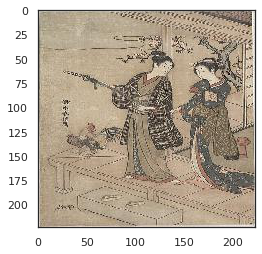

In [0]:
print(Y_train[0])
print(X_train[3][0].shape)
##-- check image (Error is occured, when using "np.float16")
plt.imshow(X_train[22], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [0]:
###-----------------------------------###
###       Cutout Random Erasing       ###
###-----------------------------------###
###-- Rondom Erasing --###
def eraser(input_img):
    ##-- Parameter
    p=0.5
    s_l=0.02
    s_h=0.4
    r_1=0.3
    r_2=1/0.3
    v_l=0
#     v_h=255
    v_h=1
    pixel_level=False
    ##--
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
        return input_img

    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img
  
###-------------------------------------###
###-- Batch dealing of Random Erasing --###
###-------------------------------------###
def RandomErase( img_train ):
  x = []
  for i in range( len(img_train) ):
    tem = eraser( img_train[i] )
    x.append( tem )
    
  x = np.array(x)
  
  return x

In [0]:
###-- Cutout Random Erasing --##
X_train = RandomErase( X_train )
print( X_train.shape )

(2527, 224, 224, 3)


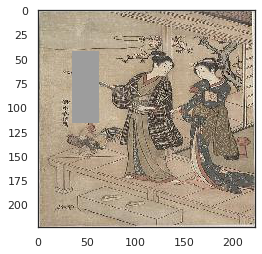

In [0]:
##-- check image (Error is occured, when using "np.float16")
plt.imshow(X_train[22], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [0]:
###-----------------------------------###
###         Data Augmentation         ###
###-----------------------------------###
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import randint

##--(Number of data, Height, Width, Channels) 
def Data_Augmentation(image):
  ######################################
  ###-- Set augmentation generator --###
  ######################################
  ##-- Rondom flip
  rotation = ImageDataGenerator(rotation_range=20)
  ##-- Parallel Movement align to vertical direction.
  shift_vertical = ImageDataGenerator(height_shift_range=0.2)
  ##-- Parallel Movement align to horizontal direction.
  shift_horizontal = ImageDataGenerator(width_shift_range=0.2)
  ##-- Shear transformation; shera_range describes "angle".
  shear = ImageDataGenerator(shear_range=5)
  ##-- [-5.0, 5.0] の範囲でランダムに画素値に値を足す。
  noise = ImageDataGenerator(channel_shift_range=5.)
  ##-- [0.3, 1.0] の範囲でランダムに明度を変更する。
  brightness = ImageDataGenerator(brightness_range=[0.3, 1.0])
  ##--
  ret = []
  for i in range( 0, len(image) ):
    tem_img = np.reshape(image[i], [-1, image[i].shape[0], image[i].shape[1], image[i].shape[2]])
    ##-- Create random number between 0 - 3.
    rand_int = randint(4)
    if rand_int == 0:
      img_rot = rotation.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 1:
      img_rot = shift_vertical.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 2:
      img_rot = shift_horizontal.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    elif rand_int == 3:
      img_rot = shear.flow( tem_img, batch_size=1 )
      img_rot = next(img_rot)
    # elif rand_int == 4:
    #   img_rot = noise.flow( tem_img, batch_size=1 )
    #   img_rot = next(img_rot)
    # elif rand_int == 5:
    #   img_rot = brightness.flow( tem_img, batch_size=1 )
    #   img_rot = next(img_rot)
    # elif rand_int == 4:
    #   img_rot = tem_img
    # #--
    # img_rot = next(img_rot)
    # #--
    ret.append( img_rot[0] )

  ret = np.array( ret )
  
  return ret

In [0]:
###-------------------------------------------------###
###         Data Augmentation and Inflation         ###
###-------------------------------------------------###
import gc

multiple = 1
img_ori = X_train.copy()
lbl_ori = Y_train.copy()
for i in range( multiple ):
  data_tem = Data_Augmentation( img_ori )
  X_train = np.append( X_train, data_tem, axis=0 )
  Y_train = np.append( Y_train, lbl_ori, axis=0 )

del img_ori, lbl_ori
gc.collect()

print(X_train.shape)
print(Y_train.shape)

(5054, 224, 224, 3)
(5054, 10)


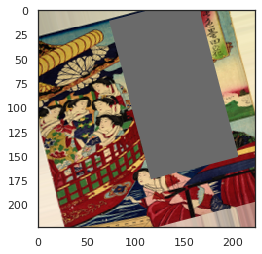

In [0]:
##-- check image (Error is occured, when using "np.float16")
plt.imshow(X_train[3050], cmap=cm.gray_r, interpolation='nearest')
plt.show()

In [0]:
###-- Shuffle dataset --###
from sklearn.utils import shuffle
X_train, Y_train = shuffle(X_train, Y_train, random_state=20191231)

###---  Definition of each Model  ---###

学習およびモデルの保存

In [0]:
##-- Model 2

def Model2(_input_shape, num_classes=10):
  model = models.Sequential()

  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (224,224,3)))
  model.add(layers.MaxPooling2D(pool_size=(2,2)))
  # model.add(layers.Dropout(0.25))

  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  # model2.add(layers.Dropout(0.25))
 
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  # model.add(layers.Dropout(0.25))

  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  # model.add(layers.Dropout(0.25))

  model.add(layers.Flatten())

  model.add(layers.BatchNormalization())
  model.add(layers.Dense(512, activation="relu"))
  model.add(layers.Dropout(0.25))
  
  model.add(layers.Dense(num_classes, activation = "softmax"))

  return model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 96)        8

In [0]:
###--------------------------###
###           ZeroDL         ###     
###--------------------------###
from tensorflow.keras import backend as K
def swish( x, beta=1. ):
  return x*K.sigmoid(beta*x)

activation = "relu"
# activation = "swish"

##-- Model3(ZeroDL)
def ZeroDL(_input_shape, num_classes=10):
  model = models.Sequential()

  model.add(layers.Conv2D(filters = 16, kernel_size = (3,3),padding="same",activation =activation, 
                          kernel_initializer='he_normal', input_shape = (224,224,3)))

  model.add(layers.Conv2D(filters = 16, kernel_size = (3,3),padding="same",activation =activation))
  model.add(layers.Dropout(0.3))

  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(filters = 32, kernel_size = (3,3),padding="same",activation =activation))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(filters = 32, kernel_size = (3,3),padding="same",activation =activation))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Dropout(0.4))

  model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding="same",activation =activation))
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(filters = 64, kernel_size = (3,3),padding="same",activation =activation))
  model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(layers.Dropout(0.4))

  model.add(layers.Flatten())

  model.add(layers.Dense(128, activation=activation))  #--512, 256
  model.add(layers.Dropout(0.5))

  # model.add(layers.Dense(128, activation='relu'))
  # model.add(layers.Dropout(0.5))

  model.add(layers.Dense(num_classes, activation = "softmax"))

  return model

In [0]:
###--------------------------###
###           Wakame         ###     
###--------------------------###
# from tensorflow.keras import backend as K
# def swish( x, beta=1. ):
#   return x*K.sigmoid(beta*x)

activation = "relu"
# activation = "swish"  #--NOT good
# activation = "elu"  #--NOT good

# from tensorflow.keras import regularizers
# l2 = 1.e-4

def build_model(_input_shape, num_classes=10):
    # Model
    model = models.Sequential()
    # Add convolution 2D
    model.add(layers.Conv2D(32, kernel_size=(3, 3),activation=activation, padding="same",
            kernel_initializer='he_normal',input_shape=_input_shape))

    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32,kernel_size=(3, 3), activation=activation))

    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32,kernel_size=5,strides=2,padding='same',activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())
    # Add dropouts to the model
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, kernel_size=(3, 3), strides=2,padding='same', activation=activation))
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, 
                           activation=activation, 
                          #  kernel_regularizer=regularizers.l2(l2)
                           ))
    # Add dropouts to the model
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation=activation))

    return model


In [0]:
##-- Select the Model
# model = ZeroDL(_input_shape=(224, 224, 3), num_classes=num_classes)
model = build_model(_input_shape=(224, 224, 3), num_classes=num_classes)  #--lr=0.0005 + Adam + epoch100-150

# model = tf.keras.applications.ResNet50(
# model = tf.keras.applications.ResNet101(
# model = tf.keras.applications.ResNet152(
    # include_top=True,
    # weights=None,
    # input_tensor=None,
    # input_shape=(224, 224, 3),
    # pooling=None,  #--"max" is global max pooling, None is ordinary max pooling
    # classes=10
    # )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 55, 55, 32)        1

In [0]:
##-- Define the optimizer
from tensorflow.keras import optimizers, losses
optimizer = optimizers.SGD(lr = 0.005, #--lr=0.01
                           momentum = 0.9, #--Default: 0.9
                           nesterov = True #--Default: False
                           )
# optimizer = optimizers.RMSprop(lr=0.001, rho=0.99)
# optimizer = optimizers.Adam(lr=0.0005)
# optimizer = optimizers.Adam(lr=0.001,
#                             beta_1=0.9, beta_2=0.999, #--Defoalt values
#                             amsgrad=True, #--AMSGrad
#                             )
##-- Compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 100
batch_size = 64 #-- Default: 128, 64, 32
##-- Early stopping as es
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=10, verbose=2)
##-- Run
history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data = (X_test,Y_test), #-- validation_split=0.2
                    verbose=2, 
                    # callbacks = [es]
                    )

Train on 5054 samples, validate on 631 samples
Epoch 1/100
5054/5054 - 19s - loss: 2.6125 - accuracy: 0.1518 - val_loss: 2.2104 - val_accuracy: 0.2108
Epoch 2/100
5054/5054 - 11s - loss: 2.0845 - accuracy: 0.2560 - val_loss: 2.0323 - val_accuracy: 0.2298
Epoch 3/100
5054/5054 - 11s - loss: 2.1356 - accuracy: 0.1806 - val_loss: 2.3041 - val_accuracy: 0.0666
Epoch 4/100
5054/5054 - 11s - loss: 2.1549 - accuracy: 0.0873 - val_loss: 2.2052 - val_accuracy: 0.0666
Epoch 5/100
5054/5054 - 11s - loss: 2.0482 - accuracy: 0.1801 - val_loss: 2.1240 - val_accuracy: 0.1648
Epoch 6/100
5054/5054 - 11s - loss: 1.9701 - accuracy: 0.2479 - val_loss: 2.7735 - val_accuracy: 0.2203
Epoch 7/100
5054/5054 - 11s - loss: 1.9726 - accuracy: 0.2851 - val_loss: 3.2926 - val_accuracy: 0.3074
Epoch 8/100
5054/5054 - 11s - loss: 2.0331 - accuracy: 0.2827 - val_loss: 5.6633 - val_accuracy: 0.1838
Epoch 9/100
5054/5054 - 11s - loss: 2.0496 - accuracy: 0.2667 - val_loss: 1.9487 - val_accuracy: 0.2758
Epoch 10/100
5054

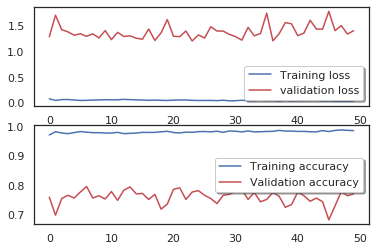

In [0]:
 # Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

検証データで精度チェック

テストデータで予測

In [0]:
###---  提出用データの読み込み  ---###

###--データの読み込み
def load(f):
    return np.load(f)['arr_0']
X_submit = load(datapath+"ukiyoe-test-imgs.npz")

###--型をint --> float変換する。
X_submit = X_submit.astype(np.float32)
###-- convert from [0:255] => [0.0:1.0]
X_submit = np.multiply(X_submit, 1.0 / 255.0)

print(X_submit.shape)

(397, 224, 224, 3)


In [0]:
###---  Prediction  ---###
predicts = np.argmax(model.predict(X_submit), axis=1)
predicts.shape

(397,)

In [0]:
###---  提出ファイル作成  ---###
import pandas as pd

submit = pd.DataFrame(data={"id": [], "y": []})
submit.id = list(range(1, predicts.shape[0]+1))
submit.y = predicts
submit.to_csv("submit.csv", index=False)

print(submit.head())

from google.colab import files
files.download("submit.csv")

   id  y
0   1  4
1   2  1
2   3  3
3   4  1
4   5  1


In [0]:
###--- テストデータでテスト ---#
##-- N = 10000; Number of test images
i = 0
N = 10000
predicts = []
while i < N:
    i = i + 100
    ##--
    tem = []
    tem_1 = []
    tem_2 = []
    tem_3 = []
    tem_4 = []
    tem_5 = []
    ##--
    #tem_1 = model_1.predict(test_imgs[i-100:i])
    tem_2 = model_2.predict(test_imgs[i-100:i])
    tem_3 = model_3.predict(test_imgs[i-100:i])
    tem_4 = model_4.predict(test_imgs[i-100:i])
    tem_5 = model_5.predict(test_imgs[i-100:i])
    #tem = tem_1 + tem_2 + tem_3 + tem_4 + tem_5
    tem = tem_2 + tem_3 + tem_4 + tem_5
    ##--
    predicts = np.append( predicts, np.argmax( tem , axis=1) )
  
predicts = predicts.astype(np.int64)

predicts.shape
print(predicts)

[2 9 3 ... 9 4 2]


In [0]:
###---  提出ファイル作成  ---###
import pandas as pd
###-- 変数predictsに予測結果を入れて下さい
###-- 型はnumpy.ndarrayで
###-- shapeは(10000,)になるはずです
###-- predicts = 
submit = pd.DataFrame(data={"ImageId": [], "Label": []})

submit.ImageId = list(range(1, predicts.shape[0]+1))
submit.Label = predicts

submit.to_csv(root.joinpath("submit.csv"), index=False)



NameError: ignored